In [1]:
import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("Torch version:[%s]"%(torch.__version__))

Torch version:[1.11.0+cu113]


In [2]:
def torch2np(x_torch):
    if x_torch is None:
        x_np = None
    else:
        x_np = x_torch.detach().cpu().numpy()
    return x_np
def np2torch(x_np,device='cuda:0'):
    if x_np is None:
        x_torch = None
    else:
        x_torch = torch.tensor(x_np,dtype=torch.float32,device=device)
    return x_torch
print ("Done.")

Done.


In [3]:
class GumbelQuantizer(nn.Module):
    def __init__(
                self, 
                z_dim, 
                embedding_num, 
                embedding_dim,
                tau_scale = 1.0,
                kld_scale = 5e-4,
                straight_through=False,
                device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
                ):
        super(GumbelQuantizer, self).__init__()
        self.embedding_num    = embedding_num
        self.embedding_dim    = embedding_dim
        self.straight_through = straight_through
        self.device     = device
        self.tau_scale  = tau_scale
        self.kld_scale  = kld_scale
        self.projection = nn.Linear(z_dim, self.embedding_num)
        self.embedding  = nn.Embedding(self.embedding_num, embedding_dim)
        # self.init_embedding()

    def init_embedding(self):
        self.embedding.weight.data.fill_(0)
        self.embedding.weight.data.fill_diagonal_(1)

    def zero_grad_for_non_diagnoal_weights(self):
        for row, grads in enumerate(self.embedding.weight.grad):
            grads[:] = 0

    def forward(self, z, hard=False):
        # force hard = True when we are in eval mode, as we must quantize
        hard   = self.straight_through if self.training else True
        logits = self.projection(z)
        soft_one_hot = F.gumbel_softmax(logits, tau=self.tau_scale, dim=1, hard=hard)
        z_q = torch.matmul(soft_one_hot, self.embedding.weight).to(self.device)
        # + kl divergence to the prior loss
        qy   = F.softmax(logits, dim=1)
        diff = self.kld_scale * torch.sum(qy * torch.log(qy + 1e-10), dim=1).mean()
        return z_q, diff

In [4]:
class GumbelQuantizedVariationalAutoEncoder(nn.Module):
    def __init__(
        self,
        name     = 'GQVAE',              
        x_dim    = 784,              # input dimension
        c_dim    = 10,               # condition dimension
        z_dim    = 15,               # latent dimension
        h_dims   = [64,32],          # hidden dimensions of encoder (and decoder)
        embedding_num   = 10,        # For VQ parameters
        embedding_dim   = 3,         # For VQ parameters
        tau_scale = 1.0,             # For VQ parameters
        kld_scale = 5e-4,            # For VQ parameters 
        actv_enc = nn.ReLU(),        # encoder activation
        actv_dec = nn.ReLU(),        # decoder activation
        actv_q   = nn.Softplus(),    # q activation
        actv_out = None,             # output activation
        device   = 'cpu'
        ):
        """
            Initialize
        """
        super(GumbelQuantizedVariationalAutoEncoder, self).__init__()
        self.name   = name
        self.x_dim  = x_dim
        self.c_dim  = c_dim
        self.z_dim  = z_dim
        self.h_dims = h_dims
        self.embedding_num = embedding_num
        self.embedding_dim = embedding_dim
        self.tau_scale = tau_scale
        self.kld_scale = kld_scale
        self.actv_enc  = actv_enc
        self.actv_dec  = actv_dec
        self.actv_q    = actv_q
        self.actv_out  = actv_out
        self.device    = device
        self.histogram = torch.zeros(self.embedding_dim).to(self.device)
        # Initialize VQ class
        self.GQ = GumbelQuantizer(self.z_dim, self.embedding_num, self.embedding_dim, self.tau_scale, self.kld_scale).to(self.device)
        # Initialize layers
        self.init_layers()
        self.init_params()
                
    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = {}
        
        # Encoder part
        h_dim_prev = self.x_dim + self.c_dim
        for h_idx,h_dim in enumerate(self.h_dims):
            self.layers['enc_%02d_lin'%(h_idx)]  = \
                nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['enc_%02d_actv'%(h_idx)] = \
                self.actv_enc
            h_dim_prev = h_dim
        self.layers['z_lin']  = nn.Linear(h_dim_prev,self.z_dim,bias=True)
        
        # Decoder part
        h_dim_prev = self.z_dim + self.c_dim
        for h_idx,h_dim in enumerate(self.h_dims[::-1]):
            self.layers['dec_%02d_lin'%(h_idx)]  = \
                nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['dec_%02d_actv'%(h_idx)] = \
                self.actv_dec
            h_dim_prev = h_dim
        self.layers['out_lin'] = nn.Linear(h_dim_prev,self.x_dim,bias=True)
        
        # Append parameters
        self.param_dict = {}
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                self.param_dict[key+'_w'] = layer.weight
                self.param_dict[key+'_b'] = layer.bias
        self.gqvae_parameters = nn.ParameterDict(self.param_dict)
        
    def xc_to_z(
        self,
        x = torch.randn(2,784),
        c = torch.randn(2,10)
        ):
        """
            x to z
        """
        if c is not None:
            net = torch.cat((x,c), dim=1)
        else:
            net = x
        for h_idx,_ in enumerate(self.h_dims):
            net = self.layers['enc_%02d_lin'%(h_idx)](net)
            net = self.layers['enc_%02d_actv'%(h_idx)](net)
        z = self.layers['z_lin'](net)
        return z
    
    def zc_to_x_recon(
        self,
        z = torch.randn(2,16),
        c = torch.randn(2,10)
        ):
        """
            z and c to x_recon
        """
        net, _ = self.GQ(z, hard=True)
        count = torch.sum(net, axis=0)
        self.histogram += count.detach()
        if c is not None:
            net = torch.cat((net,c),dim=1)
        else:
            pass
        for h_idx,_ in enumerate(self.h_dims[::-1]):
            net = self.layers['dec_%02d_lin'%(h_idx)](net)
            net = self.layers['dec_%02d_actv'%(h_idx)](net)
        net = self.layers['out_lin'](net)
        if self.actv_out is not None:
            net = self.actv_out(net)
        x_recon = net
        return x_recon

    def z_q_to_x_recon(
        self,
        z_q,
        c
        ):
        """
            z and c to x_recon
        """
        net = torch.cat((z_q,c),dim=1)
        for h_idx,_ in enumerate(self.h_dims[::-1]):
            net = self.layers['dec_%02d_lin'%(h_idx)](net)
            net = self.layers['dec_%02d_actv'%(h_idx)](net)
        net = self.layers['out_lin'](net)
        if self.actv_out is not None:
            net = self.actv_out(net)
        x_recon = net
        return x_recon

    def xc_to_x_recon(
        self,
        x = torch.randn(2,784),
        c = torch.randn(2,10)
        ):
        """
            x to x_recon
        """
        z = self.xc_to_z(x=x, c=c)
        x_recon = self.zc_to_x_recon(z=z, c=c)
        return x_recon

    def sample_x(
        self,
        c = torch.randn(2,10),
        n_sample = 1
        ):
        """
            sample x from codebook
        """
        random_integers  = np.random.permutation(self.embedding_num)[:n_sample]
        random_embedding = self.GQ.embedding.weight.data[random_integers, :]
        x_sample = self.z_q_to_x_recon(z_q=random_embedding, c=c).detach().cpu().numpy()
        return x_sample

    def init_params(self,seed=0):
        """
            Initialize parameters
        """
        # Fix random seed
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        # Init
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                nn.init.normal_(layer.weight,mean=0.0,std=0.01)
                nn.init.zeros_(layer.bias)
            elif isinstance(layer,nn.BatchNorm2d):
                nn.init.constant_(layer.weight,1.0)
                nn.init.constant_(layer.bias,0.0)
            elif isinstance(layer,nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def loss_recon(
        self,
        x               = torch.randn(2,784),
        c               = torch.randn(2,10),
        LOSS_TYPE       = 'L1+L2',
        recon_loss_gain = 1.0
        ):
        """
            Recon loss
        """
        x_recon = self.xc_to_x_recon(x=x, c=c)
        if (LOSS_TYPE == 'L1') or (LOSS_TYPE == 'MAE'):
            errs = torch.mean(torch.abs(x-x_recon),axis=1)
        elif (LOSS_TYPE == 'L2') or (LOSS_TYPE == 'MSE'):
            errs = torch.mean(torch.square(x-x_recon),axis=1)
        elif (LOSS_TYPE == 'L1+L2') or (LOSS_TYPE == 'EN'):
            errs = torch.mean(
                0.5*(torch.abs(x-x_recon)+torch.square(x-x_recon)),axis=1)
        else:
            raise Exception("VAE:[%s] Unknown loss_type:[%s]"%
                            (self.name,LOSS_TYPE))
        return recon_loss_gain*torch.mean(errs)
        
    def loss_total(
        self,
        x               = torch.randn(2,784),
        c               = torch.randn(2,10),
        LOSS_TYPE       = 'L1+L2',
        recon_loss_gain = 1.0
        ):
        """
            Total loss
        """
        loss_recon_out = self.loss_recon(
            x               = x,
            c               = c,
            LOSS_TYPE       = LOSS_TYPE,
            recon_loss_gain = recon_loss_gain
        )
        z = self.xc_to_z(x, c)
        _, loss_vq = self.GQ(z, hard=True)
        loss_total_out = loss_recon_out + loss_vq
        info           = {'loss_total_out' : loss_total_out,
                          'loss_recon_out' : loss_recon_out,
                          'loss_vq'        : loss_vq}
        return loss_total_out, info

    def debug_plot_img(
        self,
        x_train_np     = np.zeros((60000,784)),  # to plot encoded latent space 
        y_train_np     = np.zeros((60000)),      # to plot encoded latent space 
        c_train_np     = np.zeros((60000,10)),   # to plot encoded latent space
        x_test_np      = np.zeros((10000,784)),
        c_test_np      = np.zeros((10000,10)),
        c_vecs         = np.eye(10,10),
        n_sample       = 10,
        img_shape      = (28,28),
        img_cmap       = 'gray',
        figsize_image  = (10,3.25),
        figsize_latent = (10,3.25),
        DPP_GEN        = False,
        dpp_hyp        = {'g':1.0,'l':0.1}
        ):
        """
            Debug plot
        """
        n_train       = x_train_np.shape[0]
        x_train_torch = np2torch(x_train_np, device=self.device)
        # Reconstruct
        x_test_torch  = np2torch(x_test_np, device=self.device)
        c_test_torch  = np2torch(c_test_np, device=self.device)
        n_test        = x_test_np.shape[0]
        rand_idxs     = np.random.permutation(n_test)[:n_sample]
        x_recon = self.xc_to_x_recon(x=x_test_torch[rand_idxs,:], c=c_test_torch[rand_idxs]).detach().cpu().numpy()
        # Generation
        random_integers  = np.random.permutation(self.embedding_num)[:n_sample]
        random_embedding = self.GQ.embedding.weight.data[random_integers, :]
        x_sample = self.z_q_to_x_recon(z_q=random_embedding, c=c_test_torch[random_integers]).detach().cpu().numpy()
        # Plot images to reconstruct
        fig = plt.figure(figsize=figsize_image)
        for s_idx in range(n_sample):
            plt.subplot(1,n_sample,s_idx+1)
            plt.imshow(x_test_np[rand_idxs[s_idx],:].reshape(img_shape),
                       vmin=0,vmax=1,cmap=img_cmap)
            plt.axis('off')
        fig.suptitle("Images to Reconstruct",fontsize=15);plt.show()
        
        # Plot reconstructed images
        fig = plt.figure(figsize=figsize_image)
        for s_idx in range(n_sample):
            plt.subplot(1,n_sample,s_idx+1)
            plt.imshow(x_recon[s_idx,:].reshape(img_shape),
                       vmin=0,vmax=1,cmap=img_cmap)
            plt.axis('off')
        fig.suptitle("Reconstructed Images",fontsize=15);plt.show()

        # Plot generated images
        fig = plt.figure(figsize=figsize_image)
        for s_idx in range(n_sample):
            plt.subplot(1,n_sample,s_idx+1)
            plt.imshow(x_sample[s_idx,:].reshape(img_shape),
                       vmin=0,vmax=1,cmap=img_cmap)
            plt.axis('off')
        fig.suptitle("Generated Images",fontsize=15);plt.show()

In [5]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(
    root='data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test  = datasets.MNIST(
    root='data/',train=False,transform=transforms.ToTensor(),download=True)
# Training data
x_train_torch               = mnist_train.data.float().reshape(-1,784)/255.
y_train_torch               = mnist_train.targets
x_test_torch                = mnist_test.data.float().reshape(-1,784)/255.
y_test_torch                = mnist_test.targets
x_train_np,x_test_np        = torch2np(x_train_torch),torch2np(x_test_torch)
y_train_np,y_test_np        = torch2np(y_train_torch),torch2np(y_test_torch)
c_train_np,c_test_np        = np.eye(10,10)[y_train_np],np.eye(10,10)[y_test_np]
n_train,n_test              = x_train_np.shape[0],x_test_np.shape[0]
c_train_torch,c_test_torch  = np2torch(c_train_np),np2torch(c_test_np)
print ("x_train_np:%s x_test_np:%s"%(x_train_np.shape,x_test_np.shape,))
print ("c_train_np:%s c_test_np:%s"%(c_train_np.shape,c_test_np.shape,))
print ("n_train:[%d] n_test:[%d]"%(n_train,n_test))

x_train_np:(60000, 784) x_test_np:(10000, 784)
c_train_np:(60000, 10) c_test_np:(10000, 10)
n_train:[60000] n_test:[10000]


[GQVAE] instantiated with device:[cuda:0]
tensor([[ 0.6768,  0.5991,  0.1692,  ..., -1.3023, -2.3084,  0.2542],
        [-0.6167,  0.8403,  0.4204,  ...,  1.4535, -0.7380, -0.1281],
        [ 0.4605,  0.5571, -0.1358,  ..., -1.2292,  0.7306, -0.0451],
        ...,
        [-0.5359, -1.2422,  1.1943,  ..., -0.3551,  0.4307,  1.1559],
        [ 0.3688, -1.2879, -0.0398,  ..., -1.1393,  0.1326,  0.7490],
        [ 1.4786, -0.4526, -0.9680,  ...,  1.1976, -1.4292,  1.5679]],
       device='cuda:0')
Start training.
[0/100] total:[0.090] recon:[0.092] vq:[-13.019]


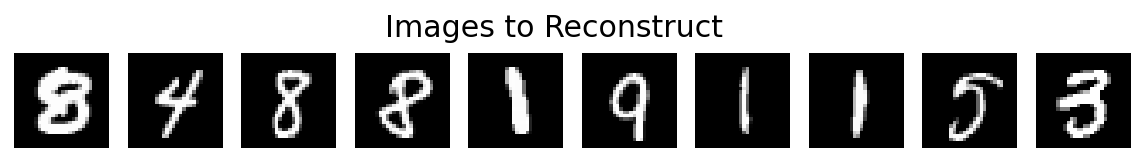

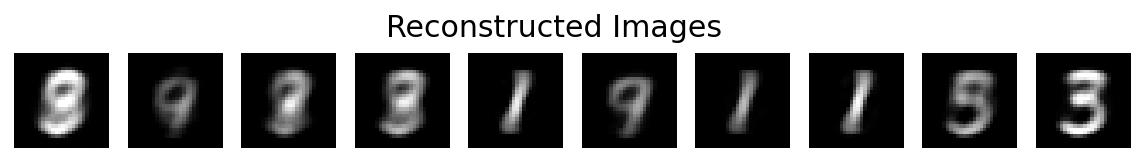

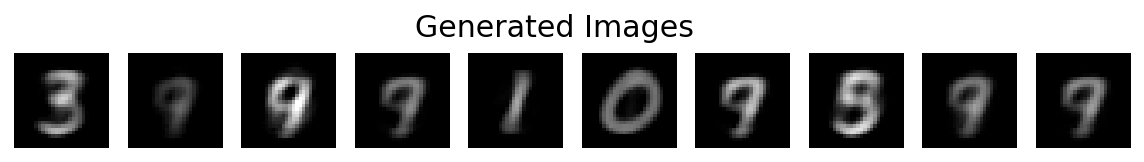

[1/100] total:[0.076] recon:[0.077] vq:[-13.010]
[2/100] total:[0.070] recon:[0.071] vq:[-9.028]
[3/100] total:[0.064] recon:[0.064] vq:[-5.683]
[4/100] total:[0.061] recon:[0.061] vq:[-4.501]
[5/100] total:[0.059] recon:[0.060] vq:[-4.128]
[6/100] total:[0.058] recon:[0.059] vq:[-3.970]
[7/100] total:[0.058] recon:[0.058] vq:[-3.854]
[8/100] total:[0.057] recon:[0.058] vq:[-3.853]
[9/100] total:[0.057] recon:[0.057] vq:[-3.803]
[10/100] total:[0.057] recon:[0.057] vq:[-3.796]


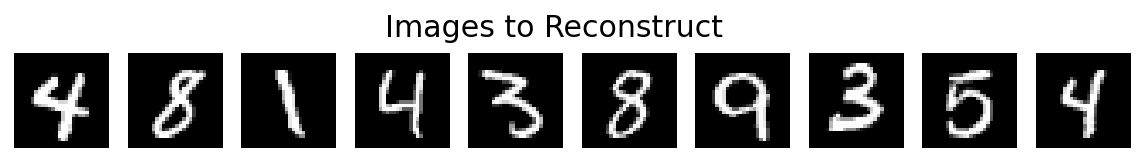

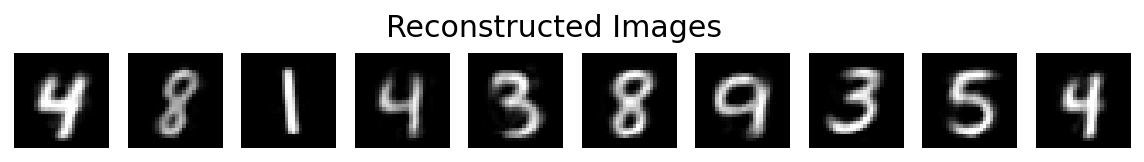

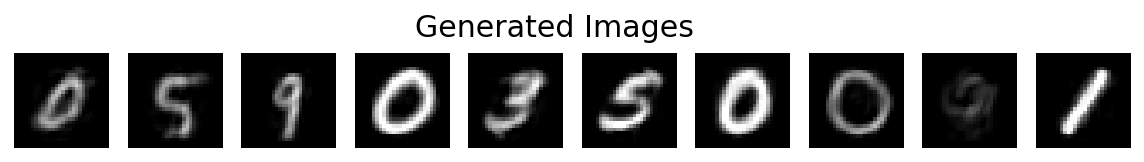

[11/100] total:[0.056] recon:[0.057] vq:[-3.815]
[12/100] total:[0.056] recon:[0.057] vq:[-3.741]
[13/100] total:[0.056] recon:[0.056] vq:[-3.745]
[14/100] total:[0.056] recon:[0.056] vq:[-3.795]
[15/100] total:[0.056] recon:[0.056] vq:[-3.789]
[16/100] total:[0.056] recon:[0.056] vq:[-3.800]
[17/100] total:[0.055] recon:[0.056] vq:[-3.804]
[18/100] total:[0.055] recon:[0.056] vq:[-3.819]
[19/100] total:[0.055] recon:[0.056] vq:[-3.843]
[20/100] total:[0.055] recon:[0.055] vq:[-3.846]


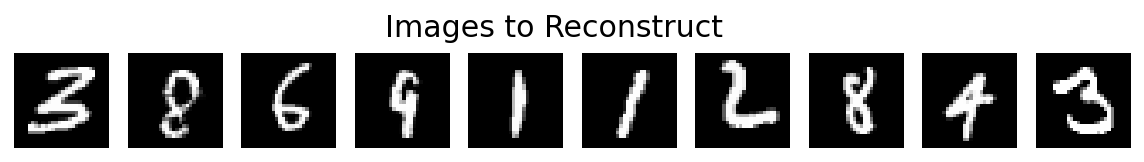

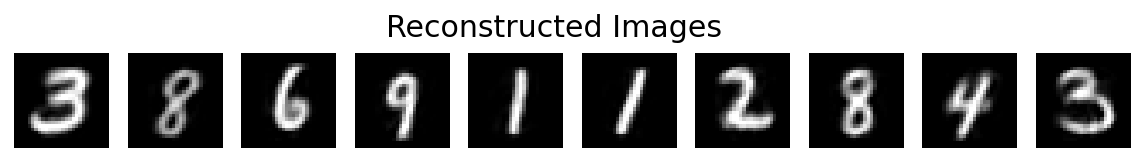

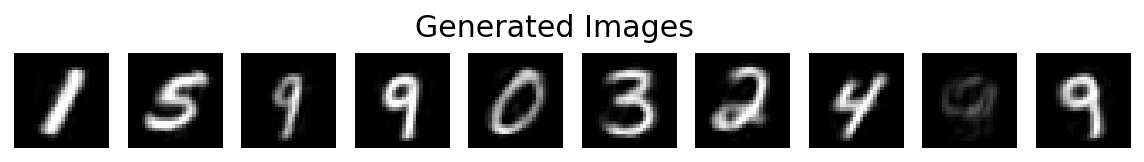

[21/100] total:[0.055] recon:[0.055] vq:[-3.915]
[22/100] total:[0.055] recon:[0.055] vq:[-3.933]
[23/100] total:[0.055] recon:[0.055] vq:[-3.949]
[24/100] total:[0.055] recon:[0.055] vq:[-3.964]
[25/100] total:[0.054] recon:[0.055] vq:[-3.982]
[26/100] total:[0.054] recon:[0.055] vq:[-4.000]
[27/100] total:[0.054] recon:[0.055] vq:[-4.028]
[28/100] total:[0.054] recon:[0.055] vq:[-4.077]
[29/100] total:[0.054] recon:[0.054] vq:[-4.073]
[30/100] total:[0.054] recon:[0.054] vq:[-4.108]


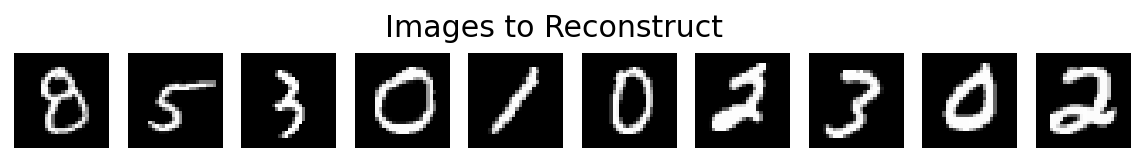

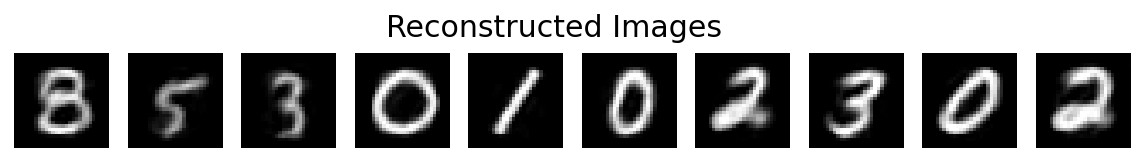

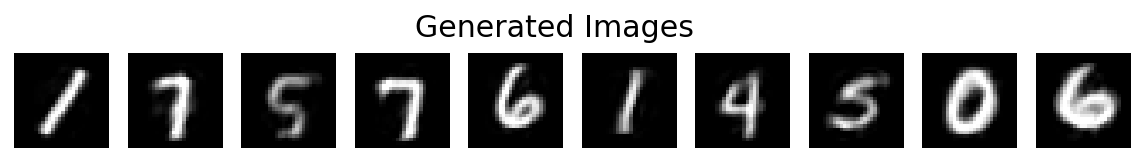

[31/100] total:[0.054] recon:[0.054] vq:[-4.131]
[32/100] total:[0.054] recon:[0.054] vq:[-4.122]
[33/100] total:[0.054] recon:[0.054] vq:[-4.185]
[34/100] total:[0.053] recon:[0.054] vq:[-4.231]
[35/100] total:[0.053] recon:[0.054] vq:[-4.239]
[36/100] total:[0.053] recon:[0.054] vq:[-4.245]
[37/100] total:[0.053] recon:[0.054] vq:[-4.279]
[38/100] total:[0.053] recon:[0.054] vq:[-4.309]
[39/100] total:[0.053] recon:[0.053] vq:[-4.290]
[40/100] total:[0.053] recon:[0.053] vq:[-4.330]


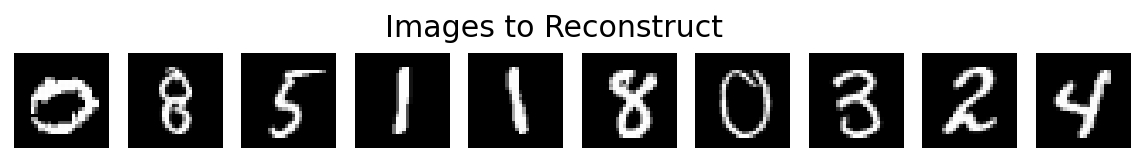

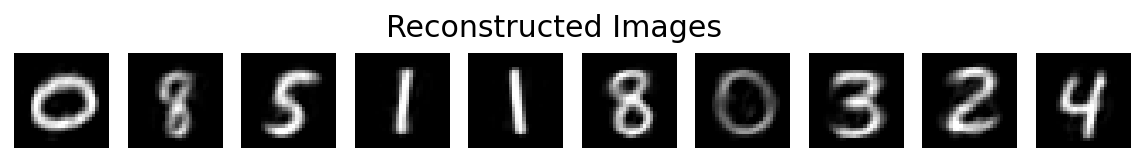

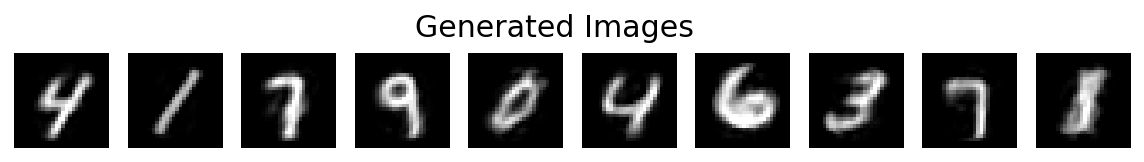

[41/100] total:[0.053] recon:[0.053] vq:[-4.366]
[42/100] total:[0.053] recon:[0.053] vq:[-4.345]
[43/100] total:[0.053] recon:[0.053] vq:[-4.355]
[44/100] total:[0.053] recon:[0.053] vq:[-4.411]
[45/100] total:[0.053] recon:[0.053] vq:[-4.411]
[46/100] total:[0.052] recon:[0.053] vq:[-4.393]
[47/100] total:[0.052] recon:[0.053] vq:[-4.381]
[48/100] total:[0.052] recon:[0.053] vq:[-4.439]
[49/100] total:[0.052] recon:[0.053] vq:[-4.443]
[50/100] total:[0.052] recon:[0.053] vq:[-4.478]


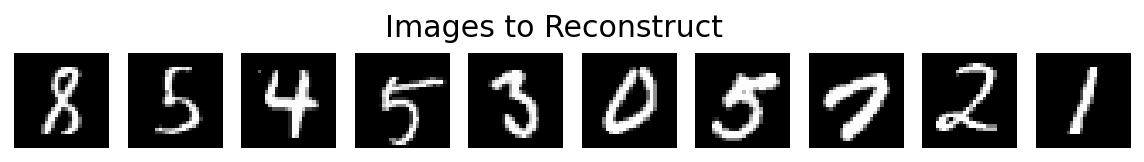

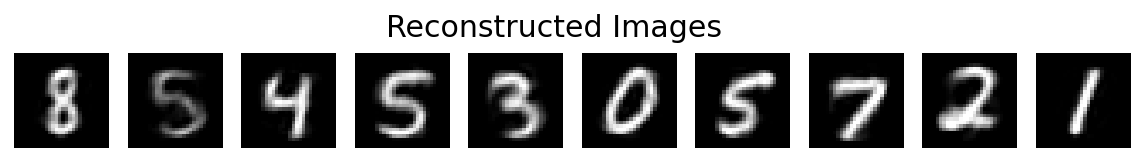

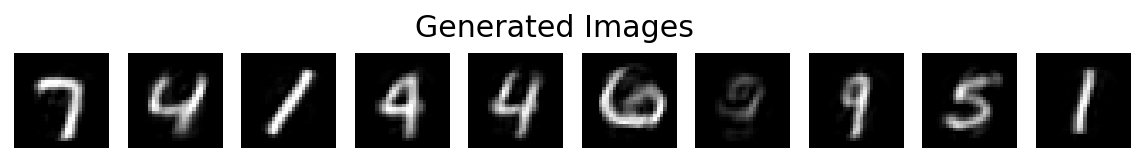

[51/100] total:[0.052] recon:[0.053] vq:[-4.440]
[52/100] total:[0.052] recon:[0.052] vq:[-4.507]
[53/100] total:[0.052] recon:[0.052] vq:[-4.518]
[54/100] total:[0.052] recon:[0.052] vq:[-4.518]
[55/100] total:[0.052] recon:[0.052] vq:[-4.518]
[56/100] total:[0.052] recon:[0.052] vq:[-4.509]
[57/100] total:[0.052] recon:[0.052] vq:[-4.554]
[58/100] total:[0.052] recon:[0.052] vq:[-4.557]
[59/100] total:[0.052] recon:[0.052] vq:[-4.583]
[60/100] total:[0.052] recon:[0.052] vq:[-4.575]


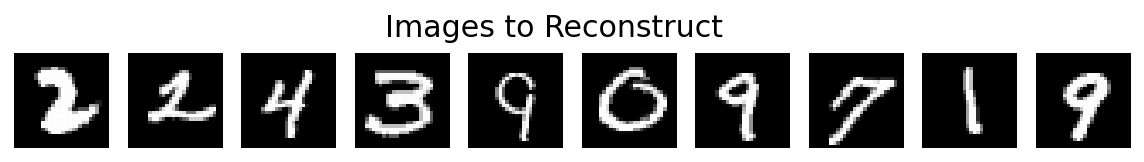

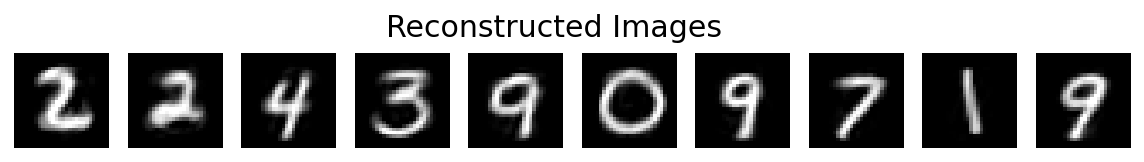

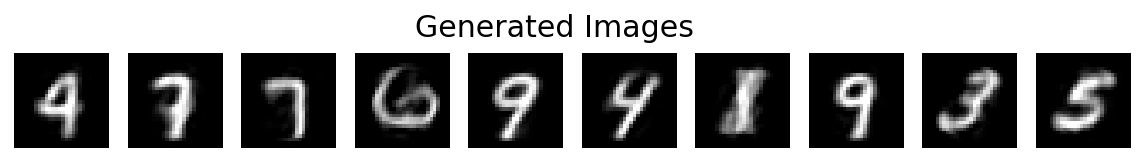

[61/100] total:[0.052] recon:[0.052] vq:[-4.564]
[62/100] total:[0.051] recon:[0.052] vq:[-4.596]
[63/100] total:[0.051] recon:[0.052] vq:[-4.588]
[64/100] total:[0.051] recon:[0.052] vq:[-4.621]
[65/100] total:[0.051] recon:[0.052] vq:[-4.637]
[66/100] total:[0.051] recon:[0.052] vq:[-4.623]
[67/100] total:[0.051] recon:[0.052] vq:[-4.648]
[68/100] total:[0.051] recon:[0.052] vq:[-4.662]
[69/100] total:[0.051] recon:[0.052] vq:[-4.707]
[70/100] total:[0.051] recon:[0.051] vq:[-4.704]


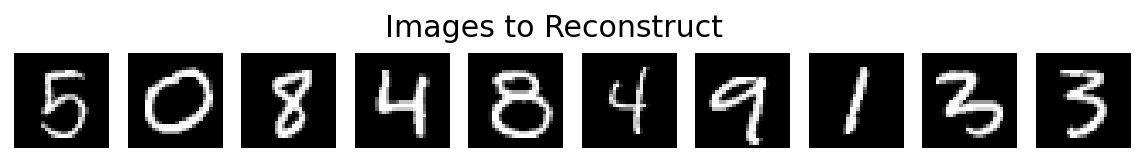

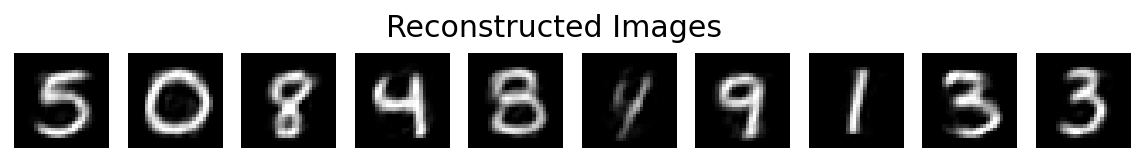

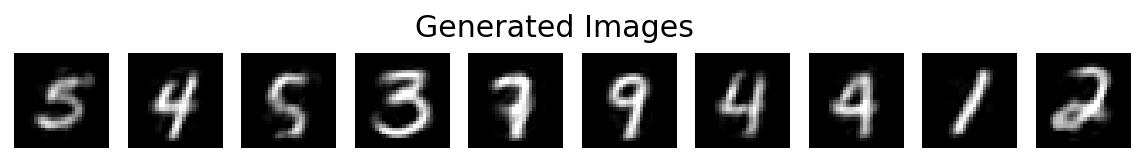

[71/100] total:[0.051] recon:[0.051] vq:[-4.697]
[72/100] total:[0.051] recon:[0.051] vq:[-4.700]
[73/100] total:[0.051] recon:[0.051] vq:[-4.701]
[74/100] total:[0.051] recon:[0.051] vq:[-4.706]
[75/100] total:[0.051] recon:[0.051] vq:[-4.719]
[76/100] total:[0.051] recon:[0.051] vq:[-4.755]
[77/100] total:[0.051] recon:[0.051] vq:[-4.764]
[78/100] total:[0.051] recon:[0.051] vq:[-4.764]
[79/100] total:[0.051] recon:[0.051] vq:[-4.778]
[80/100] total:[0.051] recon:[0.051] vq:[-4.780]


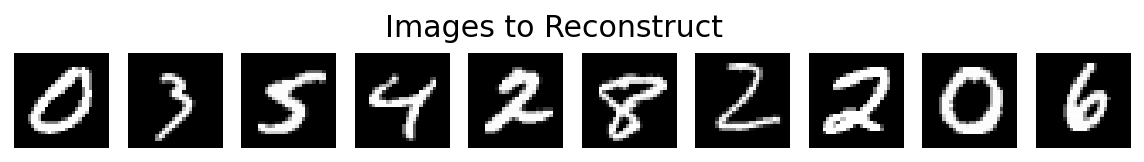

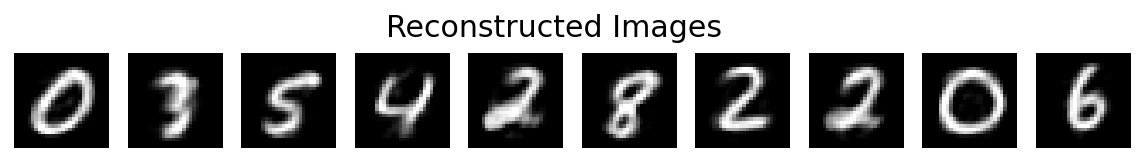

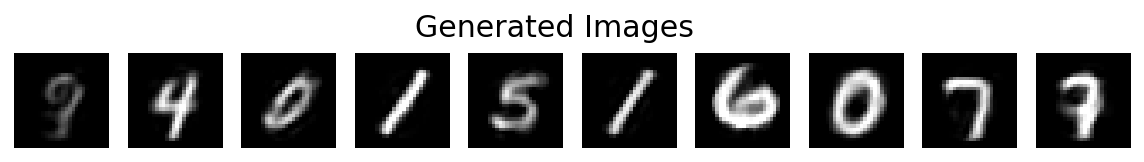

[81/100] total:[0.051] recon:[0.051] vq:[-4.764]
[82/100] total:[0.051] recon:[0.051] vq:[-4.771]
[83/100] total:[0.050] recon:[0.051] vq:[-4.806]
[84/100] total:[0.050] recon:[0.051] vq:[-4.838]
[85/100] total:[0.050] recon:[0.051] vq:[-4.844]
[86/100] total:[0.050] recon:[0.051] vq:[-4.850]
[87/100] total:[0.050] recon:[0.051] vq:[-4.860]
[88/100] total:[0.050] recon:[0.051] vq:[-4.882]
[89/100] total:[0.050] recon:[0.051] vq:[-4.904]
[90/100] total:[0.050] recon:[0.051] vq:[-4.890]


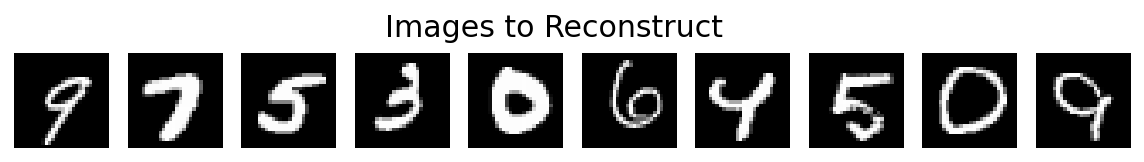

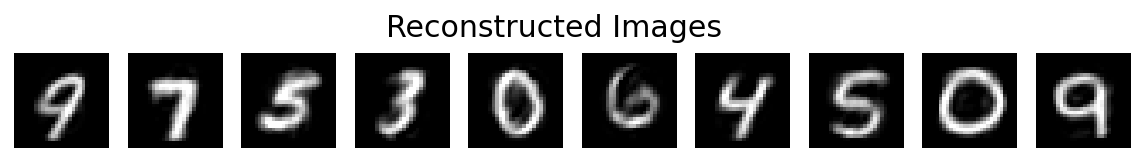

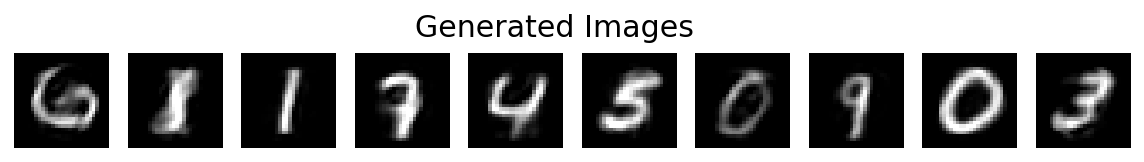

[91/100] total:[0.050] recon:[0.051] vq:[-4.900]
[92/100] total:[0.050] recon:[0.051] vq:[-4.971]
[93/100] total:[0.050] recon:[0.051] vq:[-4.928]
[94/100] total:[0.050] recon:[0.051] vq:[-4.954]
[95/100] total:[0.050] recon:[0.051] vq:[-4.924]
[96/100] total:[0.050] recon:[0.051] vq:[-4.945]
[97/100] total:[0.050] recon:[0.051] vq:[-4.964]
[98/100] total:[0.050] recon:[0.051] vq:[-4.954]
[99/100] total:[0.050] recon:[0.050] vq:[-4.957]


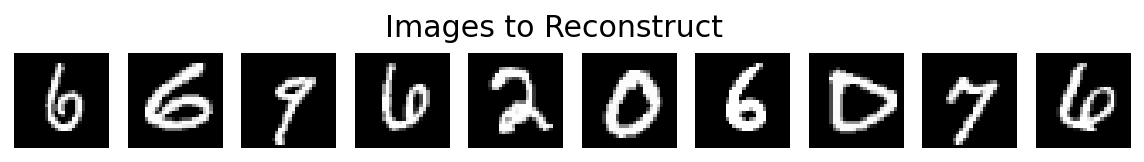

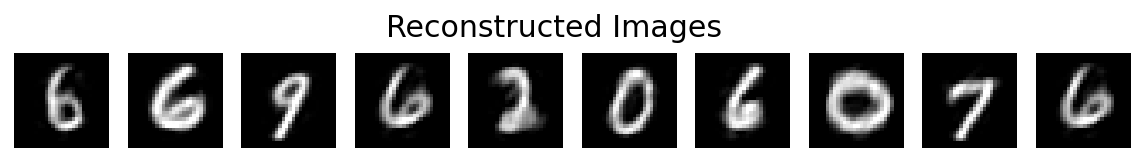

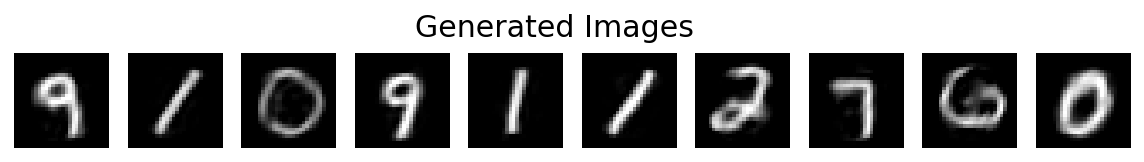

Done.


In [6]:
GQVAE = GumbelQuantizedVariationalAutoEncoder(
                                            name     = 'GQVAE',              
                                            x_dim    = 784,              # input dimension
                                            c_dim    = 10,               # condition dimension
                                            z_dim    = 32,               # latent dimension
                                            h_dims   = [256,256],          # hidden dimensions of encoder (and decoder)
                                            embedding_num   = 32,        # For VQ parameters
                                            embedding_dim   = 32,         # For VQ parameters
                                            tau_scale = 1.0,             # For VQ parameters
                                            kld_scale = 5e-4,            # For VQ parameters 
                                            actv_enc = nn.ReLU(),        # encoder activation
                                            actv_dec = nn.ReLU(),        # decoder activation
                                            actv_q   = None,    # q activation
                                            actv_out = None,             # output activation
                                            device   = 'cuda:0'    
                                            )
                                  
GQVAE = GQVAE.to(GQVAE.device)
print ("[{}] instantiated with device:[{}]".format(GQVAE.name, GQVAE.device))
print(GQVAE.GQ.embedding.weight.data)
# Hyperparameters
n_epoch,print_every,batch_size,plot_every = 100,1,128,10
n_it = (n_train//batch_size) + 1 # number of iterations
optm = torch.optim.Adam(
    params = GQVAE.parameters(),
    lr     = 0.001,
    betas  = (0.9,0.99),  # (0.9, 0.999)
    eps    = 1e-8,      # 1e-8
) 
dpi = {'x_train_np':x_train_np,'y_train_np':y_train_np,'c_train_np':c_train_np,
       'x_test_np':x_test_np,'c_test_np':c_test_np,'c_vecs':np.eye(10,10),
       'figsize_image':(10,1.25),'figsize_latent':(10,3.25),
       'DPP_GEN':True,'dpp_hyp':{'g':1.0,'l':1.0}}
# C.debug_plot_img(**dpi)
print ("Start training.")
x_train_torch = x_train_torch.to(GQVAE.device)
c_train_torch = c_train_torch.to(GQVAE.device)
for epoch in range(n_epoch):
    GQVAE.train()
    zero_to_one = float(epoch/(n_epoch-1))
    loss_recon_sum,loss_vq_sum,loss_total_sum,n_batch_sum = 0.0,0.0,0.0,0
    rand_idxs = np.random.permutation(n_train)
    for it in range(n_it):
        batch_idx     = rand_idxs[it*batch_size:(it+1)*batch_size]
        x_batch_torch = x_train_torch[batch_idx,:]
        c_batch_torch = c_train_torch[batch_idx,:]
        n_batch       = x_batch_torch.shape[0]
        # Update
        total_loss_out,loss_info = GQVAE.loss_total(
            x               = x_batch_torch,
            c               = c_batch_torch,
            LOSS_TYPE       = 'L1+L2',
            recon_loss_gain = 1.0)
        optm.zero_grad()
        total_loss_out.backward()
        optm.step()
        # Errors
        loss_total_sum = loss_total_sum + n_batch*loss_info['loss_total_out']
        loss_recon_sum = loss_recon_sum + n_batch*loss_info['loss_recon_out']
        loss_vq_sum    = loss_vq_sum + n_batch*loss_info['loss_vq']
        n_batch_sum    = n_batch_sum + n_batch
    loss_total_avg = loss_total_sum / n_batch_sum
    loss_recon_avg = loss_recon_sum / n_batch_sum
    loss_vq_avg    = loss_vq_sum / n_batch_sum
    
    # Print
    print ("[%d/%d] total:[%.3f] recon:[%.3f] vq:[%.3f]"%
           (epoch,n_epoch,loss_total_avg,loss_recon_avg, 10000*loss_vq_avg))
    
    # Plot test images
    if ((epoch%plot_every) == 0) or (epoch==(n_epoch-1)):
        GQVAE.eval()
        GQVAE.debug_plot_img(**dpi)
print ("Done.")

[2 2 2 2 2 2 2 2 2 2]
torch.Size([10, 10])
torch.Size([10, 10])


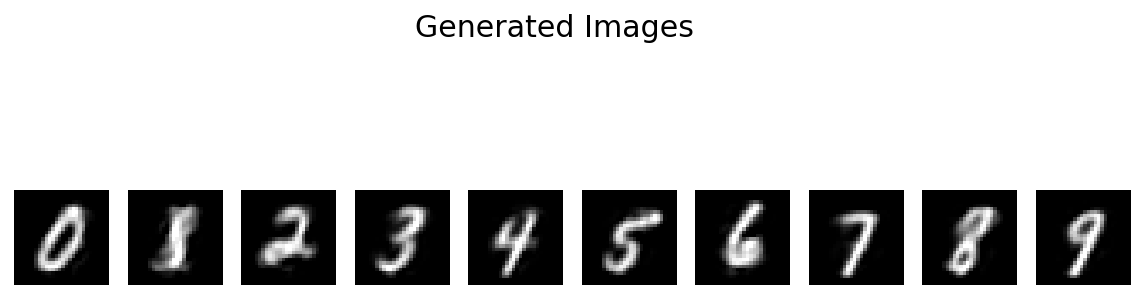

In [7]:
n_sample = 10
random_integers  = np.random.permutation(GQVAE.embedding_num)[:n_sample]
random_integers = np.array([2,2,2,2,2,2,2,2,2,2])
condition_integers = np.array([0,1,2,3,4,5,6,7,8,9])
print(random_integers)
conditon_vector = torch.zeros((10,10))
for i in range(10):
    conditon_vector[i][i] = 1
print(conditon_vector.shape)
random_embedding = GQVAE.GQ.embedding.weight.data[random_integers, :].reshape(1,-1)
print(c_test_torch[random_integers].shape)
x_sample = GQVAE.z_q_to_x_recon(z_q= GQVAE.GQ.embedding.weight.data[random_integers, :], c=conditon_vector.to(GQVAE.device)).detach().cpu().numpy()
# Plot images to reconstruct
img_shape = (28, 28)
figsize_image = (10, 3.25)
img_cmap = 'gray'
fig = plt.figure(figsize=figsize_image)
for s_idx in range(n_sample):
    plt.subplot(1,n_sample,s_idx+1)
    plt.imshow(x_sample[s_idx,:].reshape(img_shape),
                vmin=0,vmax=1,cmap=img_cmap)
    plt.axis('off')
fig.suptitle("Generated Images",fontsize=15);plt.show()